In [ ]:
import numpy as np
from osgeo import gdal, ogr, osr
import fiona
from shapely.geometry import mapping, Polygon

# Slope calculation function
def calculate_slope(dtm_array, cell_size):
    dzdx = np.gradient(dtm_array, axis=1) / cell_size
    dzdy = np.gradient(dtm_array, axis=0) / cell_size
    slope_radians = np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2))
    slope_degrees = np.degrees(slope_radians)
    slope_percent = np.sqrt(dzdx ** 2 + dzdy ** 2) * 100
    return slope_percent

# Save polygons into a Shapefile
def save_polygons_to_shapefile(polygons, output_shapefile):
    schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(output_shapefile, 'w', 'ESRI Shapefile', schema) as c:
        for i, polygon in enumerate(polygons):
            c.write({
                'geometry': mapping(polygon),
                'properties': {'id': i}
            })

# DTM file path
dtm_path = r"C:\Users\noemi\Dropbox (Politecnico Di Torino Studenti)\Magistrale\II anno_UGent\Thesis\QGIS_PYTHON\DTM+BDTRE_QGIS\DTM\DTM5\DTM5 Cervo Valley.tif"
# GDAL DTM opener
dataset = gdal.Open(dtm_path, gdal.GA_ReadOnly)
if dataset is None:
    print("Impossibile to open the DTM.")
    exit()

# DTM data read as numpy array
dtm_array = dataset.ReadAsArray()
if dtm_array is None:
    print("Impossible to read the DTM data.")
    exit()

# Information about the dimension of the cell
geo_transform = dataset.GetGeoTransform()
cell_size = geo_transform[1]

# Slope calculation
slope = calculate_slope(dtm_array, cell_size)

# Define slope thresholds
slope_thresholds = [(0, 15), (15, 30), (30, 35), (35, 70), (70, 100)]

# Create polygons for each slope threshold
for threshold in slope_thresholds:
    lower_bound, upper_bound = threshold
    steep_slope_indices = np.where((slope >= lower_bound) & (slope < upper_bound))

    polygons = []
    for i in range(len(steep_slope_indices[0])):
        row, col = steep_slope_indices[0][i], steep_slope_indices[1][i]
        x = geo_transform[0] + col * geo_transform[1]
        y = geo_transform[3] + row * geo_transform[5]
        polygon_points = [(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]
        polygons.append(Polygon(polygon_points))

    # Save polygons into a Shapefile
    if len(polygons) > 0:
        output_shapefile = f"Slopes_{lower_bound}-{upper_bound}%.shp"
        save_polygons_to_shapefile(polygons, output_shapefile)
        print(f"Polygons with slopes between {lower_bound}% and {upper_bound}% saved in {output_shapefile}")
    else:
        print(f"No slope between {lower_bound}% and {upper_bound}% found.")

# Close GDAL
dataset = None 


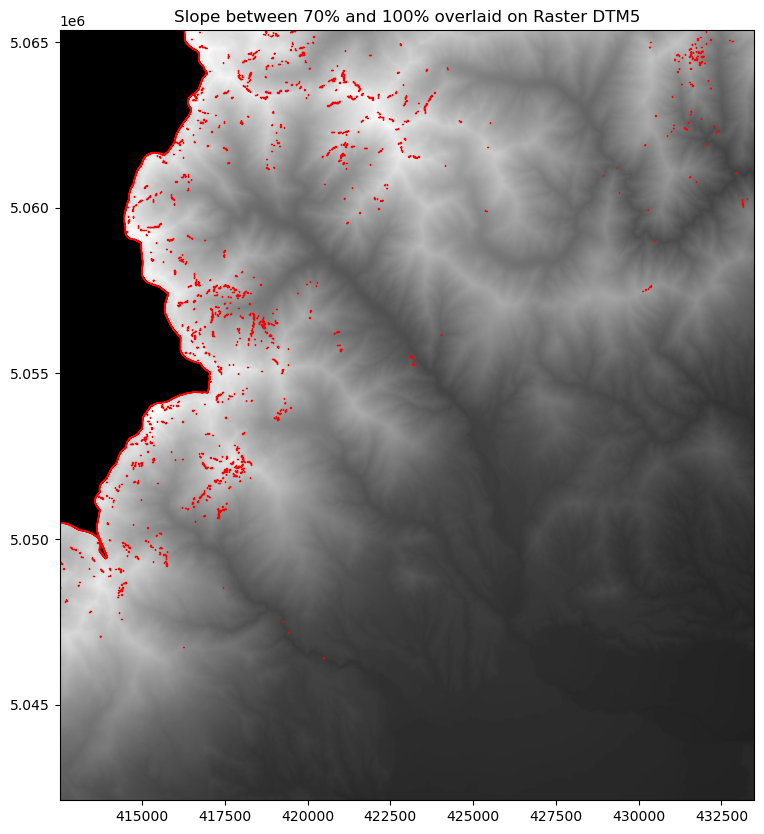

In [13]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# Function to read and plot raster and shapefile
def plot_raster_and_shapefile(raster_path, shapefile_path):
    # Read the raster file
    with rasterio.open(raster_path) as src:
        raster = src.read(1)  # Read the first band of the raster
        raster_meta = src.meta  # Get the raster metadata
        raster_crs = src.crs  # Get the raster CRS
        raster_bounds = src.bounds  # Get the raster bounds
        raster_extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]

    # Read the shapefile
    shapefile = gpd.read_file(shapefile_path)
    
    # Check if the shapefile has a CRS
    if shapefile.crs is None:
        shapefile.set_crs(raster_crs, inplace=True)
    
    # Check and, if necessary, reproject the shapefile
    elif shapefile.crs != raster_crs:
        shapefile = shapefile.to_crs(raster_crs)

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the raster in grayscale with the correct extent
    show(raster, ax=ax, cmap='gray', extent=raster_extent)
    plt.title('Slope between 70% and 100% overlaid on Raster DTM5')
    
    # Plot the shapefile in red
    shapefile.plot(ax=ax, facecolor='none', edgecolor='red')

    # Show the plot
    plt.show()

# Input the paths to the raster and shapefile
raster_path = r"C:\Users\noemi\Politecnico Di Torino Studenti Dropbox\Noemi Sobrino\Magistrale\II anno_UGent\Thesis\QGIS_PYTHON\DTM+BDTRE_QGIS\DTM\DTM5\DTM5 Cervo Valley.tif"
shapefile_path = r"C:\Users\noemi\Politecnico Di Torino Studenti Dropbox\Noemi Sobrino\Magistrale\II anno_UGent\Thesis\QGIS_PYTHON\Python\Check_slope_70-100%_polygons.shp"
# Execute the function to plot the files
plot_raster_and_shapefile(raster_path, shapefile_path)
